<a href="https://colab.research.google.com/github/SilvanaJ90/usergioarboleda-bootcamp_IA/blob/main/Two_Datasets_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

def preprocess_data(csv_path1, csv_path2):
    # Load both datasets
    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)

    # Convert 'Timestamp' to datetime
    df1['Timestamp'] = pd.to_datetime(df1['Timestamp'], unit='s')
    df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], unit='s')

    # Merge the two datasets on 'Timestamp'
    df = pd.merge(df1, df2, on='Timestamp', suffixes=('_bitstamp', '_coinbase'))

    # Replace NaN values in df1 with values from df2
    df['Close'] = df['Close_bitstamp'].combine_first(df['Close_coinbase'])
    df['Weighted_Price'] = df['Weighted_Price_bitstamp'].combine_first(df['Weighted_Price_coinbase'])

    # Keep only relevant columns
    df = df[['Timestamp', 'Close', 'Weighted_Price']]

    # Filter for 'Timestamp' >= '2017'
    df = df[df['Timestamp'] >= "2017"]

    # Set 'Timestamp' as the index and resample to hourly data
    df.set_index('Timestamp', inplace=True)
    df = df.resample('h').mean()

    print(df.head())

    n = len(df)
    train_df = df[0:int(n * 0.7)]
    val_df = df[int(n * 0.7):int(n * 0.9)]
    test_df = df[int(n * 0.9):]
    num_features = df.shape[1]

    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    train_df = train_df.diff().dropna()
    val_df = val_df.diff().dropna()
    test_df = test_df.diff().dropna()
    print(train_df.shape)
    print(val_df.shape)
    print(test_df.shape)
    return train_df, val_df, test_df, train_mean, train_std


In [ ]:
import tensorflow as tf

def create_dataset(df, sequence_length, batch_size):
    data = df.values
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=len(x)).batch(batch_size)
    return dataset


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(test_df, predictions, train_mean, train_std):
    predictions = (predictions * train_std['Close']) + train_mean['Close']
    test_df['Close'] = (test_df['Close'] * train_std['Close']) + train_mean['Close']

    plt.figure(figsize=(10, 6))
    plt.plot(test_df.index[sequence_length:], test_df['Close'][sequence_length:], color='b', label='Actual Data')
    plt.plot(test_df.index[sequence_length:], predictions, color='r', label='Predictions', zorder=5)
    plt.xlabel('Date')
    plt.ylabel('BTC Price')
    plt.title('BTC Price Forecasting')
    plt.legend()
    plt.show()


In [ ]:
csv_path1 = 'bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
csv_path2 = 'coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv'
train_df, val_df, test_df, train_mean, train_std = preprocess_data(csv_path1, csv_path2)

                          Close  Weighted_Price
Timestamp                                      
2017-01-01 00:00:00  968.463158      968.453607
2017-01-01 01:00:00  966.990526      967.044872
2017-01-01 02:00:00  966.956429      966.995921
2017-01-01 03:00:00  965.437627      965.426872
2017-01-01 04:00:00  966.022500      966.012060
(12379, 2)
(3537, 2)
(1768, 2)


In [ ]:
sequence_length = 24  # Number of hours to look back for prediction
batch_size = 64

train_dataset = create_dataset(train_df, sequence_length, batch_size)
val_dataset = create_dataset(val_df, sequence_length, batch_size)
test_dataset = create_dataset(test_df, sequence_length, batch_size)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, train_df.shape[1]), return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(train_dataset, validation_data=val_dataset, epochs=10)

mse = model.evaluate(test_dataset)
print(f"Test MSE: {mse}")



Epoch 1/10

194/194 [==============================] - 7s 19ms/step - loss: 3.7509e-04 - val_loss: 5.9566e-05
Epoch 2/10
194/194 [==============================] - 3s 16ms/step - loss: 3.7090e-04 - val_loss: 5.8223e-05
Epoch 3/10
194/194 [==============================] - 3s 15ms/step - loss: 3.6959e-04 - val_loss: 6.2191e-05
Epoch 4/10
194/194 [==============================] - 3s 16ms/step - loss: 3.6864e-04 - val_loss: 6.8689e-05
Epoch 5/10
194/194 [==============================] - 3s 16ms/step - loss: 3.7001e-04 - val_loss: 5.7684e-05
Epoch 6/10
194/194 [==============================] - 3s 16ms/step - loss: 3.6222e-04 - val_loss: 5.6391e-05
Epoch 7/10
194/194 [==============================] - 3s 16ms/step - loss: 3.5814e-04 - val_loss: 5.5690e-05
Epoch 8/10
194/194 [==============================] - 3s 16ms/step - loss: 3.5757e-04 - val_loss: 5.5485e-05
Epoch 9/10
194/194 [==============================] - 3s 15ms/step - loss: 3.5709e-04 - val_loss: 5.6099e-05
Epoch 10/10
28/2

55/55 [==============================] - 1s 5ms/step


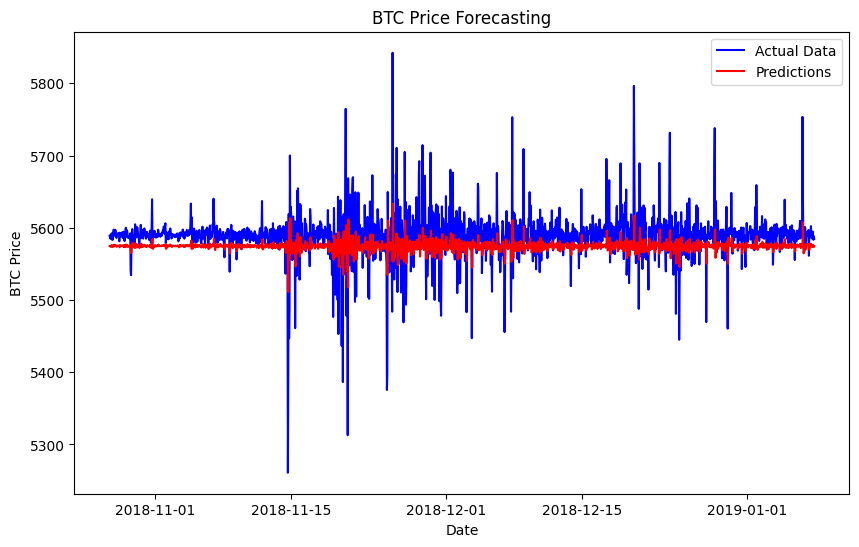

In [ ]:
import numpy as np
# Make predictions
test_data = test_df.values
x_test = []
for i in range(len(test_data) - sequence_length):
    x_test.append(test_data[i:i + sequence_length])
x_test = np.array(x_test)
predictions = model.predict(x_test)

# Plot predictions
plot_predictions(test_df, predictions, train_mean, train_std)
